In [1]:
import numpy as np
from scipy.stats import wishart, norm, multivariate_normal

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

import corner

In [2]:
params = {'font.family': 'DejaVu Serif',
          'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'xtick.direction':'in',
          'ytick.direction':'in',
          'ytick.labelsize':'large','font.size':19}
plt.rcParams.update(params)
inches_to_cm = 2.54
figsize = (40/inches_to_cm, 13/inches_to_cm)
dpi = 180

### Define Model

In [3]:
maxx = 20
ndim = 7
mu1 = np.random.uniform(-2.0, -1.0, ndim)
mu2 = np.random.uniform(1.0, 2.0, ndim)

cov1 = np.diag(np.random.uniform(1., 1.5, ndim))
cov1 = wishart.rvs(df=ndim * 8, scale=cov1 / ndim / 8)

cov2 = np.diag(np.random.uniform(1., 1.5, ndim))
cov2 = wishart.rvs(df=ndim * 4, scale=cov2 / ndim / 4)

f = np.random.uniform(1, 3, 2)
f /= np.sum(f)

def log_prob(x):
    lp1 = multivariate_normal.logpdf(x, mean=mu1, cov=cov1)
    lp2 = multivariate_normal.logpdf(x, mean=mu2, cov=cov2)
    
    pdf = np.logaddexp(lp1 + np.log(f[0]), lp2 + np.log(f[1]))
    return pdf

true = []
mu = [mu1, mu2]
cov = [cov1, cov2]
for ii in range(2):
    true.append(multivariate_normal.rvs(size = int(1000000 * f[ii]), mean=mu[ii], cov=cov[ii]))
true = np.vstack(true)

### Sample Using Varaha

In [4]:
def get_likelihood_threshold(lkl, lkl_thr, nsel, discard_prob):
    ''' Find the likelihood threshold that encolses a probability'''
    
    w = np.exp(lkl - np.max(lkl))
    npoints = len(w)
    sumw = np.sum(w)
    prob = w/sumw
    idx = np.argsort(prob)
    ecdf = np.cumsum(prob[idx])
    F = np.linspace(np.min(ecdf), 1., npoints)
    prob_stop_thr = lkl[idx][ecdf >= discard_prob][0]
    
    lkl_stop_thr = np.flip(np.sort(lkl))
    lkl_stop_thr = lkl_stop_thr[nsel]
    lkl_thr = min(lkl_stop_thr, prob_stop_thr)

    truncp = np.sum(w[lkl < lkl_thr]) / sumw
            
    return lkl_thr, truncp

def sample_from_bins(xrange, dx, bu, ninbin):
    
        ndim = xrange.shape[0]
        xlo, xhi = xrange.T[0] + dx * bu, xrange.T[0] + dx * (bu+1)
        x = np.vstack([np.random.uniform(xlo[kk], xhi[kk], size = (npb, ndim)) for kk, npb in enumerate(ninbin)])
        return x

def get_bins(log_deltaV, ndim, cycle):

    mbin = np.exp(-log_deltaV/ndim)
    if cycle % 2 == 0:
        nbins = (mbin * 2 ** np.random.uniform(-1, 1, size = (400000, ndim)) + 0.5).astype(int)
    else:
        nbins = np.maximum(1, norm.rvs(loc = mbin, scale = mbin ** 0.5, size = (400000, ndim))).astype(int)
    nbins = np.maximum(1, nbins)
    nbin = nbins[np.argmin(np.abs(1 - np.exp(np.log(nbins).sum(axis=1) + log_deltaV)))]

    return nbin

In [5]:
#User provided
enc_prob = 0.999 #The approximate upper limit on the final probability enclosed by histograms.
nsel = 2000# number of largest log-likelihood samples selected to estimate lkl_thr for the next cycle.
xrange = np.vstack([[-maxx, maxx]  for ii in range(ndim)]) #Start with a large rectangular bix same as emcee.
dx = np.diff(xrange, axis = 1).flatten()
loglkl_thr = -1e15 # Ideally it has to be -np.inf but sometimes users can provide a starting likelihood threshold.
#Sampler
V = 1
nbin = np.ones(ndim)
binunique = np.array([ndim * [0]]) #There is only one unique bin in the beginning
nmc = nmc_eff = 100000 # Number of samples at which likelihood is calculated in each cycle
ninbin = [nmc] # Number of samples in each unique bin. There is only one so all samples go there
allx, allloglkl, neffective = np.transpose([[]] * ndim), [], 0
trunc_p = 1e-10 #How much probability analysis removes with evolution
cycle = 1
neff_varaha = 0

while neff_varaha < 10000:
    x = sample_from_bins(xrange, dx, binunique, ninbin)
    loglkl = log_prob(x)
    idxsel = np.where(loglkl > loglkl_thr)
    allx = np.append(allx, x[idxsel], axis = 0)
    allloglkl = np.append(allloglkl, loglkl[idxsel])
    ninj = len(allloglkl)

    at_final_threshold = np.round(enc_prob/trunc_p) - np.round(enc_prob/(1 - enc_prob)) == 0
    if not(at_final_threshold):
        loglkl_thr, truncp = get_likelihood_threshold(allloglkl, loglkl_thr, nsel, 1 - enc_prob - trunc_p)
        trunc_p += truncp
    
    idxsel = np.where(allloglkl > loglkl_thr)
    
    allloglkl = allloglkl[idxsel]
    allx = allx[idxsel]
    lw = allloglkl - np.max(allloglkl)
    w = np.exp(lw)
    neff_varaha = np.sum(w) ** 2 / np.sum(w ** 2)
    nrec = len(allloglkl)

    V *= (nrec / ninj)
    log_deltaV = np.log(V) - 0.5 * np.log(nrec)

    nbin = get_bins(log_deltaV, ndim, cycle)
    dx = np.diff(xrange, axis = 1).flatten() / nbin
    binidx = ((allx - xrange.T[0]) / dx.T).astype(int) #bin indexs of the samples
    
    # A fast way to histogram
    binunique = np.unique(binidx, axis = 0)
    ninbin = ((nmc // binunique.shape[0] + 1) * np.ones(binunique.shape[0])).astype(int)
    
    print(cycle,len(allloglkl),np.round(neff_varaha),len(binunique),np.round(np.max(allloglkl), 1), np.round(loglkl_thr, 1), trunc_p, V)
    cycle += 1
    if cycle > 500:
        break

1 2000 3.0 607 -18.6 -116.3 1e-10 0.02
2 2000 2.0 585 -13.3 -77.3 1.0000000000000002e-10 0.004756242568370987
3 2000 3.0 570 -12.1 -52.5 1.000001971359846e-10 0.0011794773883127062
4 2000 3.0 377 -10.4 -37.4 3.147498856156846e-10 0.0003090873659100383
5 2000 17.0 637 -9.7 -25.8 6.570231917694202e-06 6.030384663155562e-05
6 2000 43.0 363 -9.6 -20.7 0.0006809992287766419 1.9201989056378164e-05
7 8458 217.0 920 -9.4 -20.2 0.0009998832320584645 1.6983208557863277e-05
8 14719 279.0 1270 -8.4 -20.2 0.0009998832320584645 1.6983208557863277e-05
9 20869 401.0 1832 -8.4 -20.2 0.0009998832320584645 1.6983208557863277e-05
10 25990 475.0 1647 -8.4 -20.2 0.0009998832320584645 1.6983208557863277e-05
11 32405 612.0 1741 -8.4 -20.2 0.0009998832320584645 1.6983208557863277e-05
12 39306 737.0 2004 -8.4 -20.2 0.0009998832320584645 1.6983208557863277e-05
13 45775 885.0 2088 -8.4 -20.2 0.0009998832320584645 1.6983208557863277e-05
14 52471 1004.0 2375 -8.4 -20.2 0.0009998832320584645 1.6983208557863277e-05
1

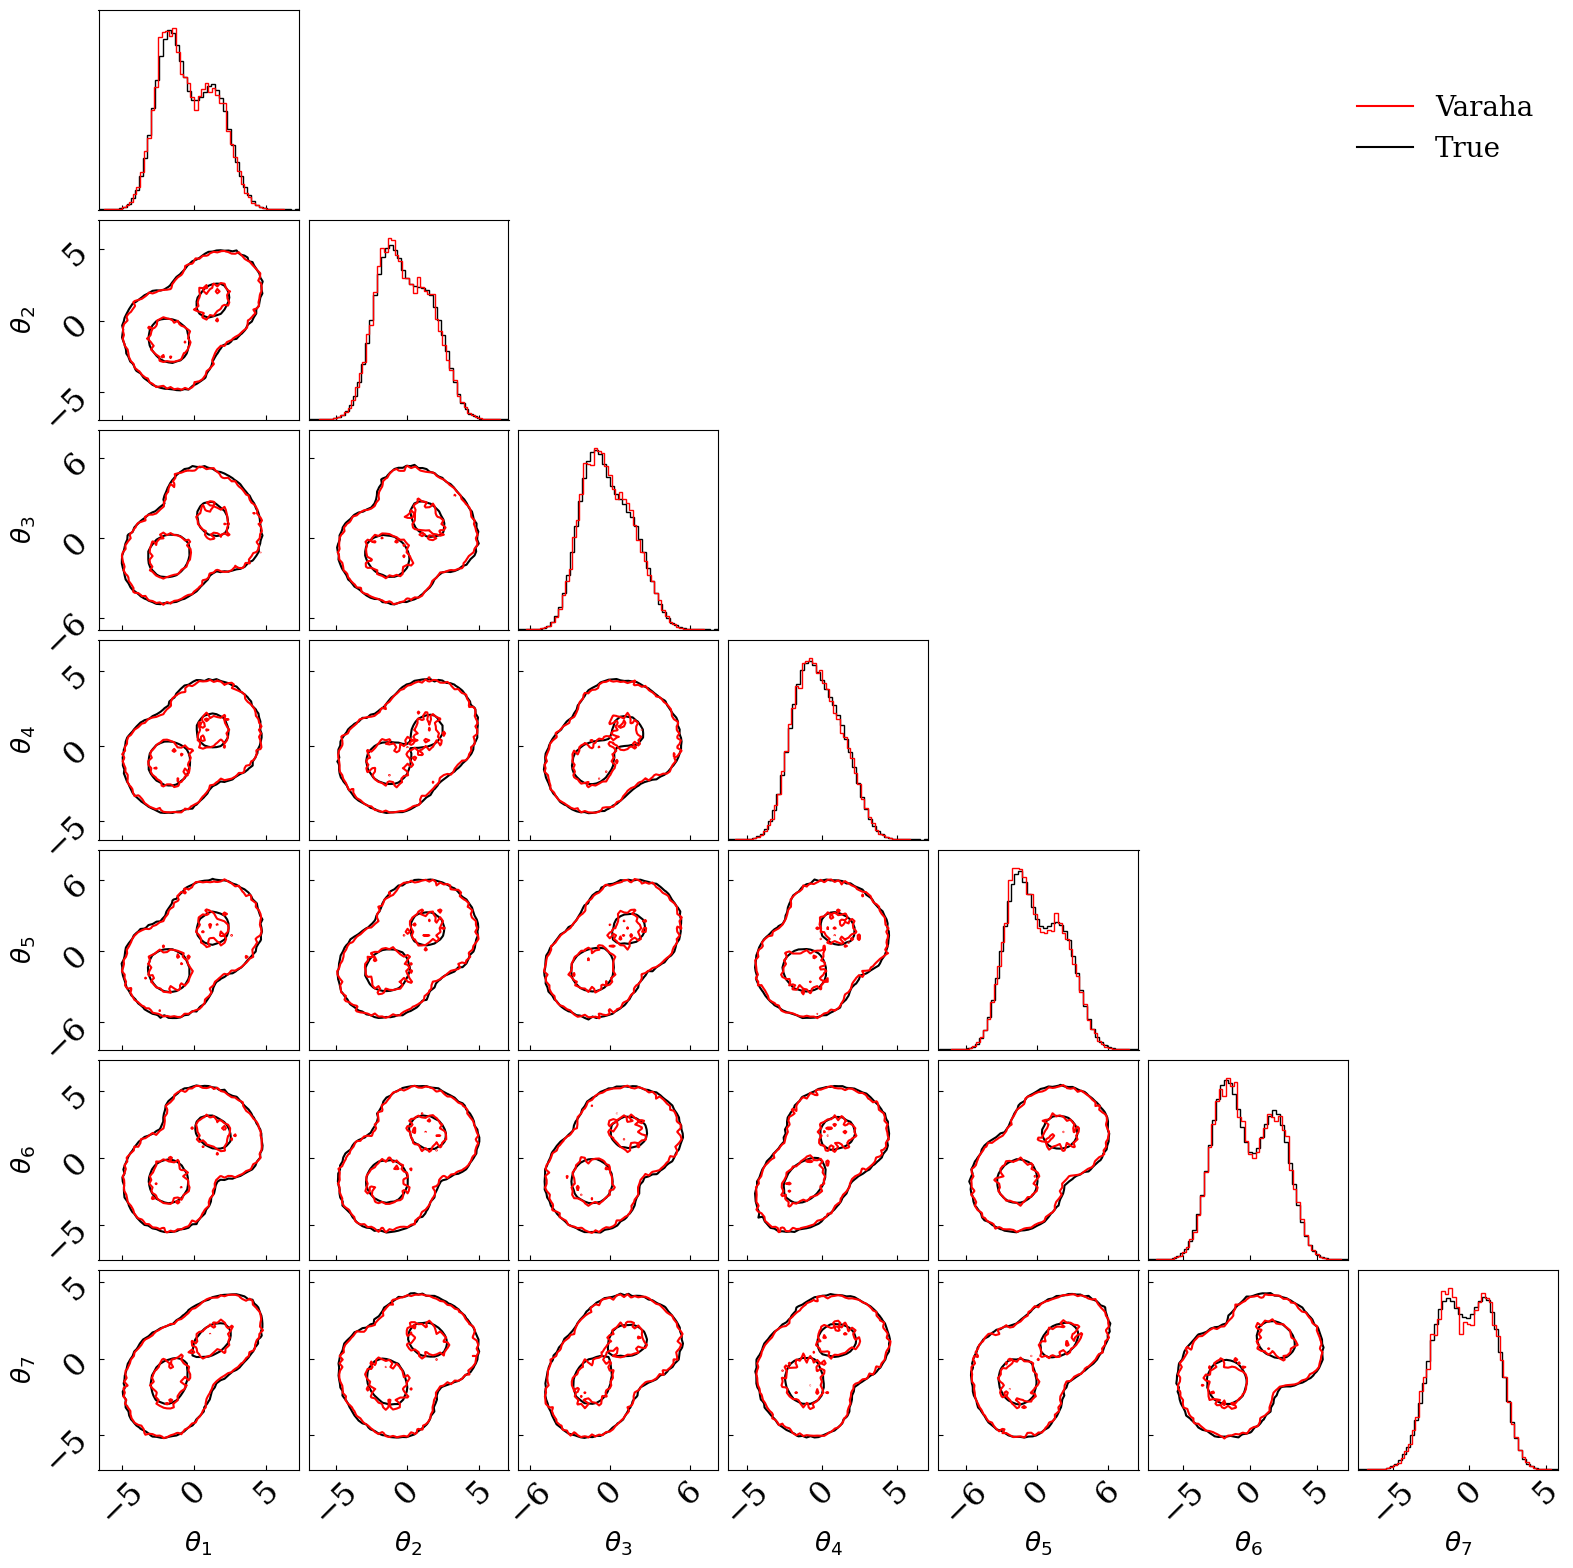

In [6]:
idx = np.where(w > 0.0001)

l=[]
for ii in range(ndim):
    l.append(r'$\theta_{' + str(ii+1) + '}$')
hh = dict(density=True, color = 'black')
figure = corner.corner(true, bins = 50, levels=(0.5, 0.99), plot_density=False, 
                       plot_datapoints=False, color = 'black',labels=l, hist_kwargs=hh, max_n_ticks=5)
hh = dict(density=True, color = 'red')
corner.corner(allx[idx], fig=figure, color='red', bins = 50, levels=(0.5, 0.99), 
              plot_density=False, plot_datapoints=False, weights=w[idx], hist_kwargs=hh, max_n_ticks=3)
plt.legend(handles=[mlines.Line2D([], [], color='red', label='Varaha'), 
                    mlines.Line2D([], [], color='black', label='True')], fontsize=20, frameon=False, 
           bbox_to_anchor=(1, ndim), loc="upper right")
#plt.savefig('files/bimodal_gaussian.jpg', dpi = 200., bbox_inches  = 'tight')